# Fitting

In [12]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap, DilutedKrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss, SpectrumDistance
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity, generate_unitary, reshuffle
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, mean_spacing


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [13]:
def non_markovianity(channel1, channel2):
    SO1 = channel1.superoperator
    SO2 = channel2.superoperator

    SO = SO2@np.linalg.inv(SO1)
    choi = reshuffle(SO)
    eig = np.linalg.eigvals(choi)
    mask = np.real(eig) < 0
    fraction = sum(mask)/len(eig)
    magnitude = np.sum(eig[mask])/np.sum(np.abs(eig))

    return fraction, np.abs(magnitude)

## Non-Markovian

In [14]:
fraction_list = []
magnitude_list = []

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=16.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=16.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=24.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=24.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=32.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=32.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

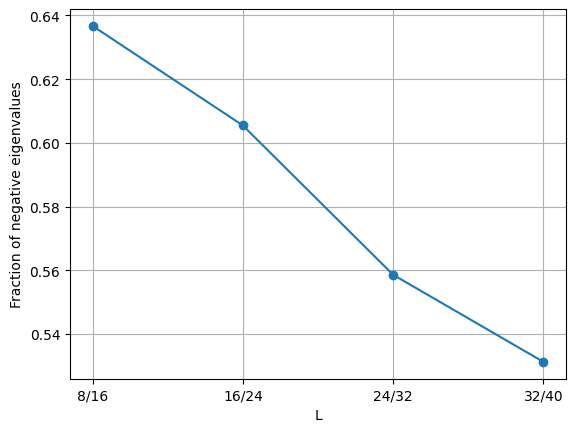

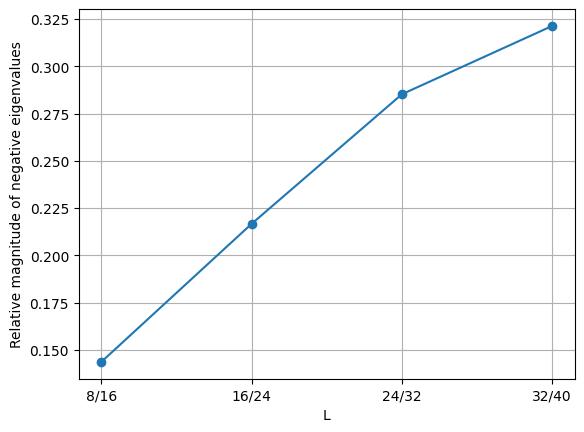

In [15]:
plt.plot(fraction_list, "-o")
plt.xlabel("L")
plt.ylabel("Fraction of negative eigenvalues")
#custom ticks
plt.xticks(np.arange(4), ["8/16", "16/24", "24/32", "32/40"])
plt.grid()

plt.savefig("figures/fraction_x-x8.png")
plt.show()

plt.plot(magnitude_list, "-o")
plt.xlabel("L")
plt.ylabel("Relative magnitude of negative eigenvalues")
plt.xticks(np.arange(4), ["8/16", "16/24", "24/32", "32/40"])
plt.grid()

plt.savefig("figures/magnitude_x-x8.png")
plt.show()


In [16]:
fraction_list = []
magnitude_list = []

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=16.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=24.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=32.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

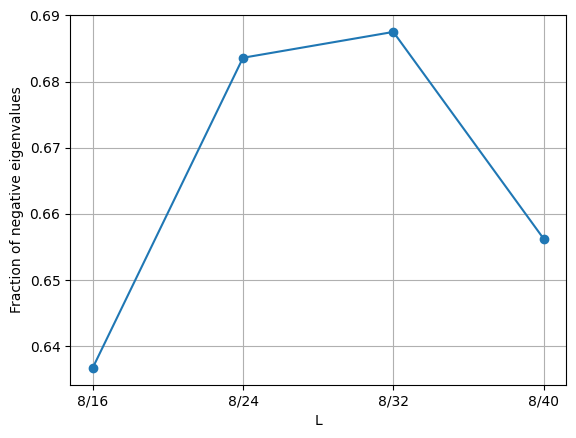

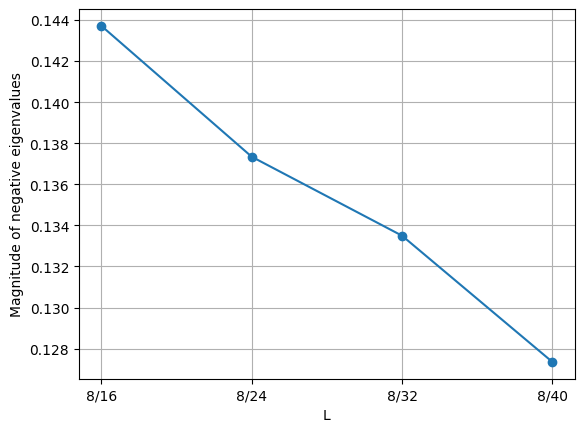

In [17]:
plt.plot(fraction_list, "-o")
plt.xlabel("L")
plt.ylabel("Fraction of negative eigenvalues")
#custom ticks
plt.xticks(np.arange(4), ["8/16", "8/24", "8/32", "8/40"])
plt.savefig("figures/fractions_8-x.png")
plt.grid()

plt.show()

plt.plot(magnitude_list,"-o")
plt.xlabel("L")
plt.ylabel("Magnitude of negative eigenvalues")
plt.xticks(np.arange(4), ["8/16", "8/24", "8/32", "8/40"])
plt.grid()

plt.savefig("figures/magnitude_8_x.png")
plt.show()


In [18]:
fraction_list = []
magnitude_list = []

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=16.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=24.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=32.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

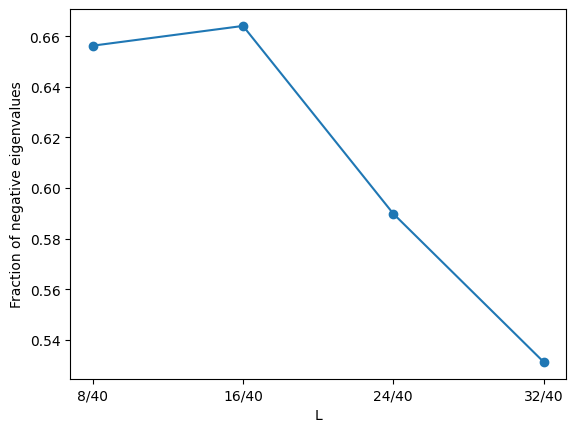

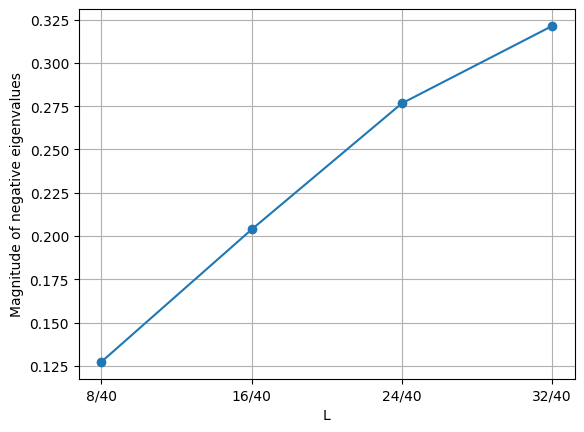

In [19]:
plt.plot(fraction_list, "-o")
plt.xlabel("L")
plt.ylabel("Fraction of negative eigenvalues")
#custom ticks
plt.xticks(np.arange(4), ["8/40", "16/40", "24/40", "32/40"])
plt.savefig("figures/magnitude_x-40.png")
plt.show()

plt.plot(magnitude_list,"-o")
plt.xlabel("L")
plt.ylabel("Magnitude of negative eigenvalues")
plt.xticks(np.arange(4), ["8/40", "16/40", "24/40", "32/40"])
plt.grid()

plt.savefig("figures/magnitude_x-40.png")
plt.show()


In [22]:
fraction_list = []
magnitude_list = []

channel1 = pkl.load(open("models/L=8.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=24.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=24.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=40.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=40.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=56.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=56.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=72.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=72.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=88.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

channel1 = pkl.load(open("models/L=88.model", "rb"))[0].channel
channel2 = pkl.load(open("models/L=104.model", "rb"))[0].channel

fraction, magnitude = non_markovianity(channel1, channel2)
fraction_list.append(fraction)
magnitude_list.append(magnitude)

#channel1 = pkl.load(open("models/L=104.model", "rb"))[0].channel
#channel2 = pkl.load(open("models/L=120.model", "rb"))[0].channel

#fraction, magnitude = non_markovianity(channel1, channel2)
#fraction_list.append(fraction)
#magnitude_list.append(magnitude)

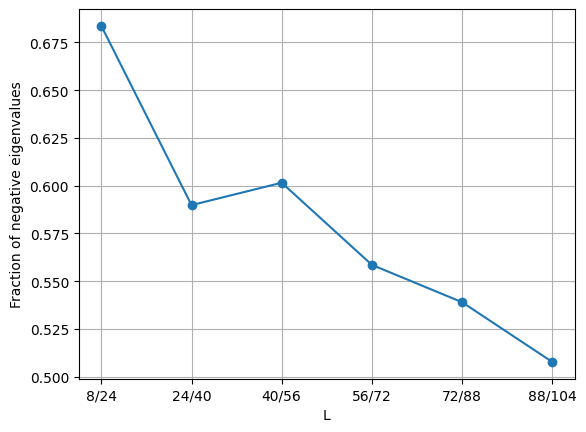

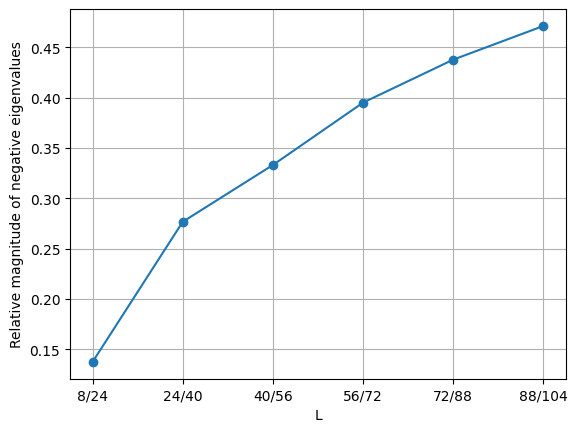

In [23]:
plt.plot(fraction_list, "-o")
plt.xlabel("L")
plt.ylabel("Fraction of negative eigenvalues")
#custom ticks
plt.xticks(np.arange(6), ["8/24", "24/40", "40/56", "56/72", "72/88", "88/104"])
plt.grid()

plt.savefig("figures/fraction_8-104.png")
plt.show()

plt.plot(magnitude_list,"-o")
plt.xlabel("L")
plt.ylabel("Relative magnitude of negative eigenvalues")
plt.xticks(np.arange(6), ["8/24", "24/40", "40/56", "56/72", "72/88", "88/104"])
plt.grid()
plt.savefig("figures/magnitude_8-104.png")
plt.show()
